In [1]:
from joblib import Parallel, delayed
import os
os.environ['R_HOME'] = '/public/home/liuzj/softwares/anaconda3/envs/mouseNN/lib/R'
# os.environ['R_HOME'] = '/public/home/liuzj/softwares/anaconda3/envs/hormone/lib/R'
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
import rpy2.ipython.html
rpy2.ipython.html.init_printing()
from jpy_tools.rTools import py2r, r2py, r_inline_plot, rHelp, trl, rSet, rGet, ad2so, so2ad, so2md, rcontext, Trl, r2py_re, py2r_re, RR, FR
from jpy_tools import loadPkl, toPkl
rBase = importr('base')
rUtils = importr('utils')
dplyr = importr('dplyr')
reticulate = importr('reticulate')
R = ro.r
T = Trl()
R("options(browser='firefox', shiny.port=6533, max.print=200)")
%load_ext rpy2.ipython

No module named 'seaborn._oldcore'


2024-03-31 14:48:44.154089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

<Figure size 100x100 with 0 Axes>

In [2]:
from jpy_tools import singleCellTools

Global seed set to 0


In [3]:
import scanpy as sc
import pandas as pd
import numpy as np

In [4]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import marsilea as ma
import marsilea.plotter as mp
# plt.rcParams['figure.dpi'] = 150
font_dirs = ["/public/home/mowp/test/fonts/"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams["font.family"] = "Arial"
sns.despine(top=True, right=True)
from itertools import product
from functools import reduce
import patchworklib as pw
from jpy_tools.otherTools import pwRecoverSeaborn, pwStack, F, pwShow
pw.show = pwShow
fc_recoverSns = pwRecoverSeaborn()
import seaborn.objects as so
from cycler import cycler
dt_snsStyle = {**sns.axes_style('ticks'), "legend.frameon": False, "axes.spines.top":False, "axes.spines.right":False, "axes.prop_cycle":cycler(color=['grey'])}
so.Plot.config.theme.update(dt_snsStyle)
from jpy_tools.soExt import Axhline, Axvline, mvLegToAx
plt.set_loglevel('Warning')

<Figure size 640x480 with 0 Axes>

# load Data

In [5]:
ad = sc.read_10x_mtx("/public/home/liuzj/test/filtered_gene_bc_matrices/hg19", var_names='gene_ids') #pbmc data

In [6]:
ad.layers['count'] = ad.X.copy()
ead = singleCellTools.EnhancedAnndata(ad, 'count')

2024-03-31 14:49:14.400 | WARNING  | jpy_tools.singleCellTools:rawLayer:358 - rawLayer will be overwritten by count and all the related objects will be re-initialized


In [7]:
ead.initLayer()

# QC

In [15]:
ead.qc.removeDoubletByScDblFinder()

2024-03-31 14:35:37.927 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:174 - start to transfer adata to R
2024-03-31 14:35:54.241 | INFO     | jpy_tools.singleCellTools.detectDoublet:byScDblFinder:180 - start to calculate doublet score
2024-03-31 14:35:54 - WARNING - R[write to console]: Creating ~5000 artificial doublets...

2024-03-31 14:36:02 - WARNING - R[write to console]: Dimensional reduction

2024-03-31 14:36:03 - WARNING - R[write to console]: Evaluating kNN...

2024-03-31 14:36:06 - WARNING - R[write to console]: Training model...

2024-03-31 14:36:07 - WARNING - R[write to console]: iter=0, 265 cells excluded from training.

2024-03-31 14:36:10 - WARNING - R[write to console]: iter=1, 242 cells excluded from training.

2024-03-31 14:36:16 - WARNING - R[write to console]: iter=2, 214 cells excluded from training.

2024-03-31 14:36:20 - WARNING - R[write to console]: Threshold found:0.458

2024-03-31 14:36:21 - WARNING - R[write to console]: 138 (5.1%) doub

In [16]:
ead

enhancedAnndata: AnnData object with n_obs × n_vars = 2562 × 32738
    var: 'gene_symbols'
    uns: 'EnhancedAnndata_rawLayer', 'log1p'
    obsm: 'scDblFinder'
    layers: 'count', 'raw', 'normalize_log'
rawLayer: count

In [ ]:
# you can also run the following code to remove ambient RNA
# ead.qc.removeAmbientBySoupx(ad_raw)

# Clustering

## Only One Sample

### APR

In [8]:
ead.norm.normByApr()

In [9]:
ead

enhancedAnndata: AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_symbols', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'EnhancedAnndata_rawLayer', 'log1p', 'hvg', 'pca', 'lastNorm'
    obsm: 'X_pca'
    layers: 'count', 'raw', 'normalize_log'
rawLayer: count

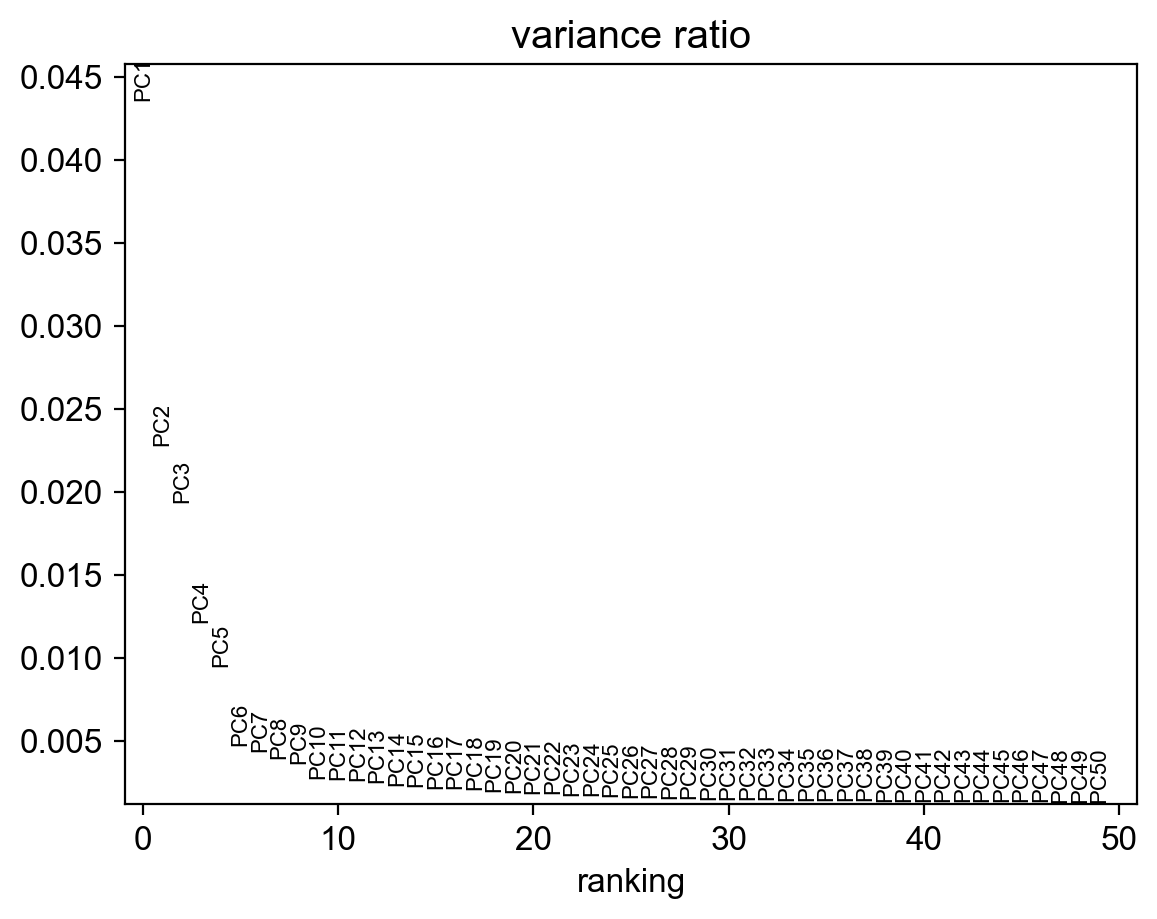

In [10]:
sc.pl.pca_variance_ratio(ead, 50)

In [11]:
sc.pp.neighbors(ead.ad, n_neighbors=25, n_pcs=20, metric='cosine')

#### find the optimal resolution

In [12]:
ls_res = [round(x,2) for x in list(np.arange(0.1, 1.1, 0.02))]

2024-03-31 14:49:25.966 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1110 - clustering using leiden algorithm
2024-03-31 14:49:25.968 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1112 - used res: [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08]
res:   0%|          | 0/50 [00:00<?, ?it/s]

silhouette_score: 100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


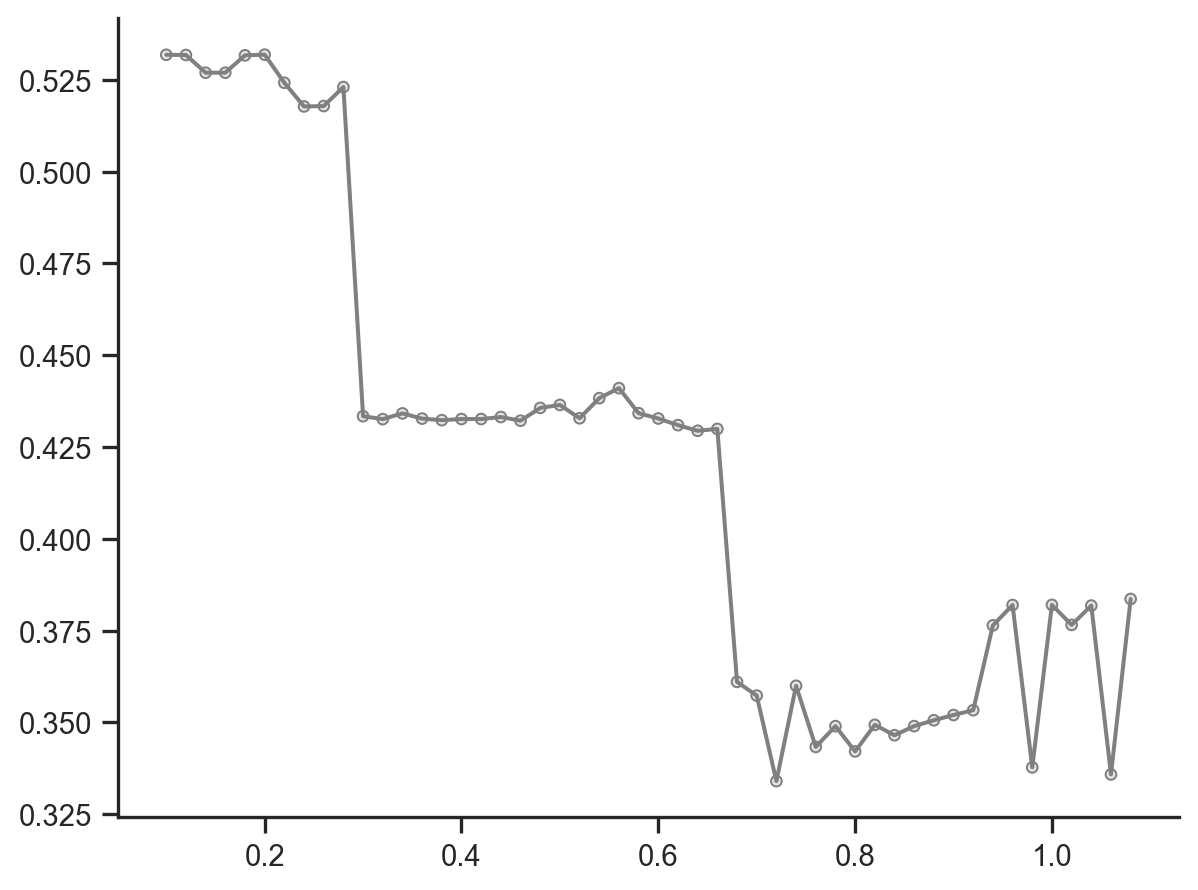

{0.1: 0.53181475,
 0.12: 0.5317606,
 0.14: 0.52694416,
 0.16: 0.52694416,
 0.18: 0.5316762,
 0.2: 0.53185785,
 0.22: 0.52420145,
 0.24: 0.51774794,
 0.26: 0.51786,
 0.28: 0.5230269,
 0.3: 0.43339384,
 0.32: 0.4325986,
 0.34: 0.43416333,
 0.36: 0.43274134,
 0.38: 0.4323121,
 0.4: 0.4326219,
 0.42: 0.4326219,
 0.44: 0.43317473,
 0.46: 0.4321706,
 0.48: 0.4356525,
 0.5: 0.43646792,
 0.52: 0.43283358,
 0.54: 0.43830332,
 0.56: 0.44103584,
 0.58: 0.43421468,
 0.6: 0.43276897,
 0.62: 0.43095952,
 0.64: 0.42942604,
 0.66: 0.42992902,
 0.68: 0.36104274,
 0.7: 0.35730943,
 0.72: 0.33401245,
 0.74: 0.35997826,
 0.76: 0.34333554,
 0.78: 0.34899062,
 0.8: 0.34211448,
 0.82: 0.34934402,
 0.84: 0.3465132,
 0.86: 0.3489908,
 0.88: 0.35059297,
 0.9: 0.3520199,
 0.92: 0.35333508,
 0.94: 0.3764259,
 0.96: 0.38196966,
 0.98: 0.33776125,
 1.0: 0.38201404,
 1.02: 0.37656385,
 1.04: 0.38181877,
 1.06: 0.33583635,
 1.08: 0.38361573}

In [13]:
ead.cl.getShilouetteScore(ls_res, obsm='X_pca', metric='cosine', pcs=20)

In [18]:
ead.obs['Cluster'] = ead.obsm['leiden']['0.2']

#### UMAP

In [15]:
sc.tl.umap(ead.ad, 0.1)

2024-03-31 15:27:01.537 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1582 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')


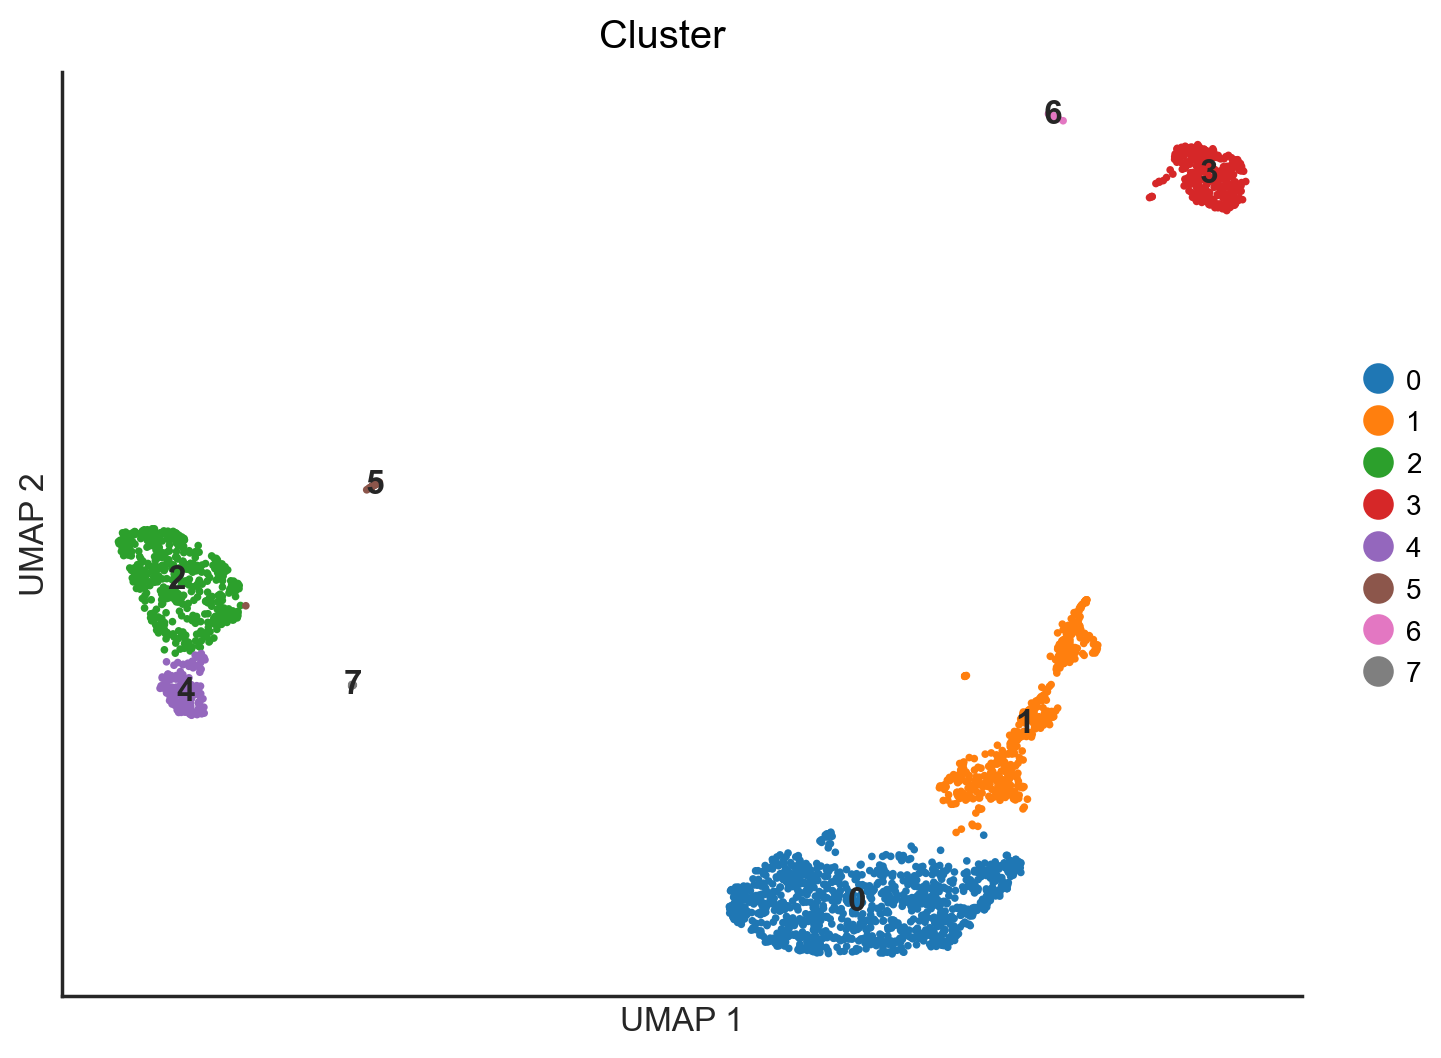

In [78]:
ead.pl.embedding('umap', color='Cluster', legendInFig=True)

2024-03-31 15:27:03.555 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1582 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')
2024-03-31 15:27:04.083 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1582 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object')


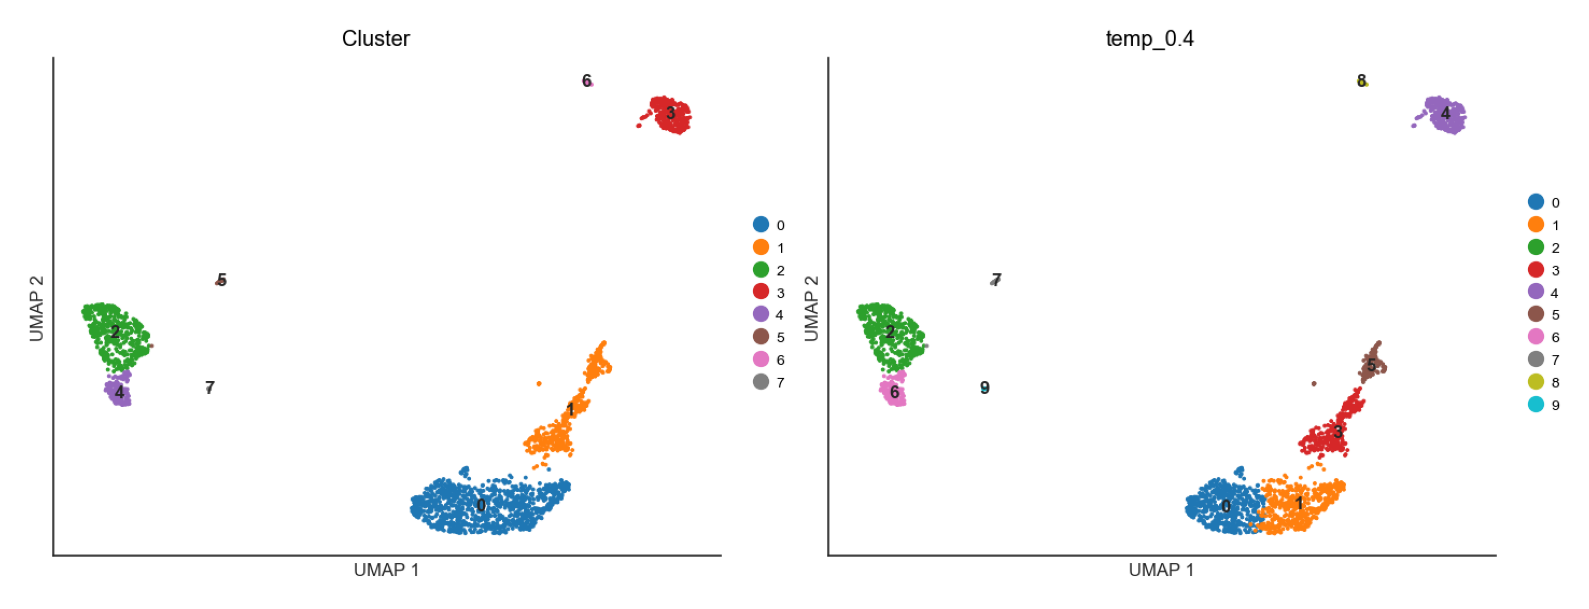

In [79]:
ead.pl.embedding('umap', color=['Cluster', 'temp_0.4'], legendInFig=True).show()

<Axes: >

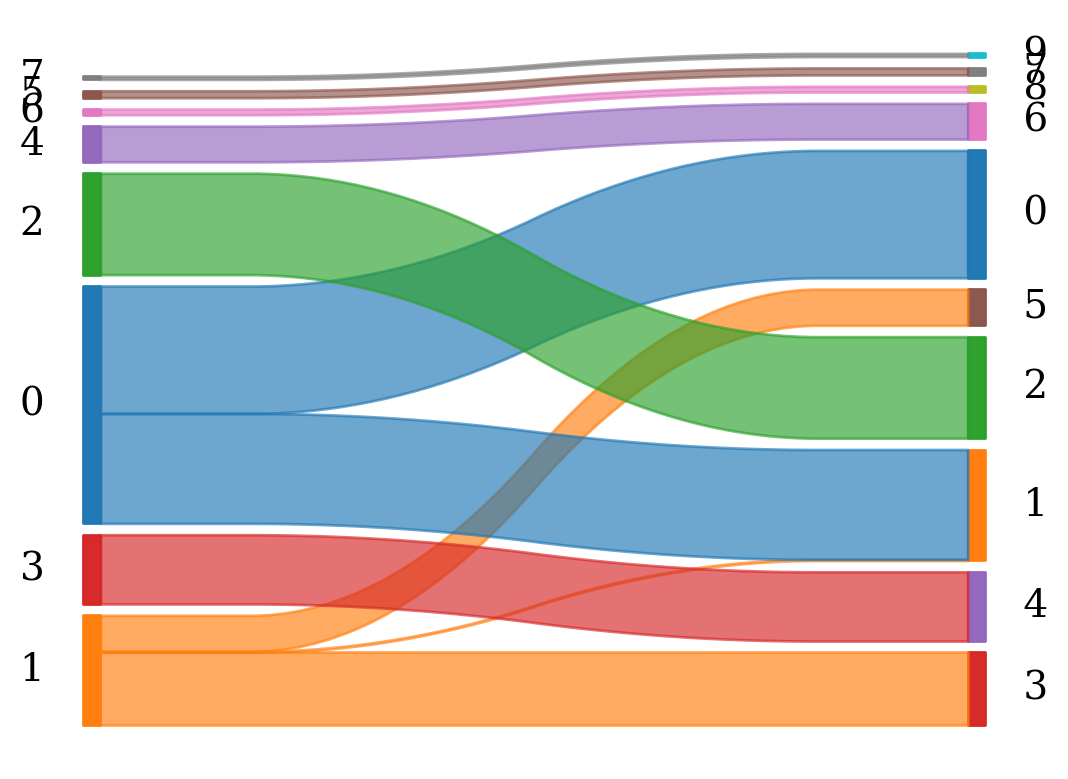

In [23]:
ead.pl.clusterSankey('Cluster', 'temp_0.4')

#### find marker

In [24]:
ead.cl.getClusterSpecGeneByCellex("Cluster")

In [31]:
pd.concat([ead.uns['Cluster_cellexES'].query("enrichScore > @x", engine='python').value_counts('Cluster').rename(x) for x in np.arange(0.8, 1, 0.05)], axis=1)
# 0.9 is a good threshold

,0.80,0.85,0.90,0.95
Cluster,,,,
7,53,30,15,3
4,51,35,17,5
6,49,27,15,5
5,41,23,10,1
2,35,20,10,2
1,29,18,7,2
3,23,12,2,0
0,0,0,0,0


In [50]:
dt_specGenes = ead.uns['Cluster_cellexES'].query("enrichScore > 0.9", engine='python').sort_values(['Cluster', 'enrichScore'], ascending=[True, False]).groupby("Cluster")['gene'].agg(list).to_dict()

In [52]:
dt_specGenes = {x:y for x,y in dt_specGenes.items() if y}

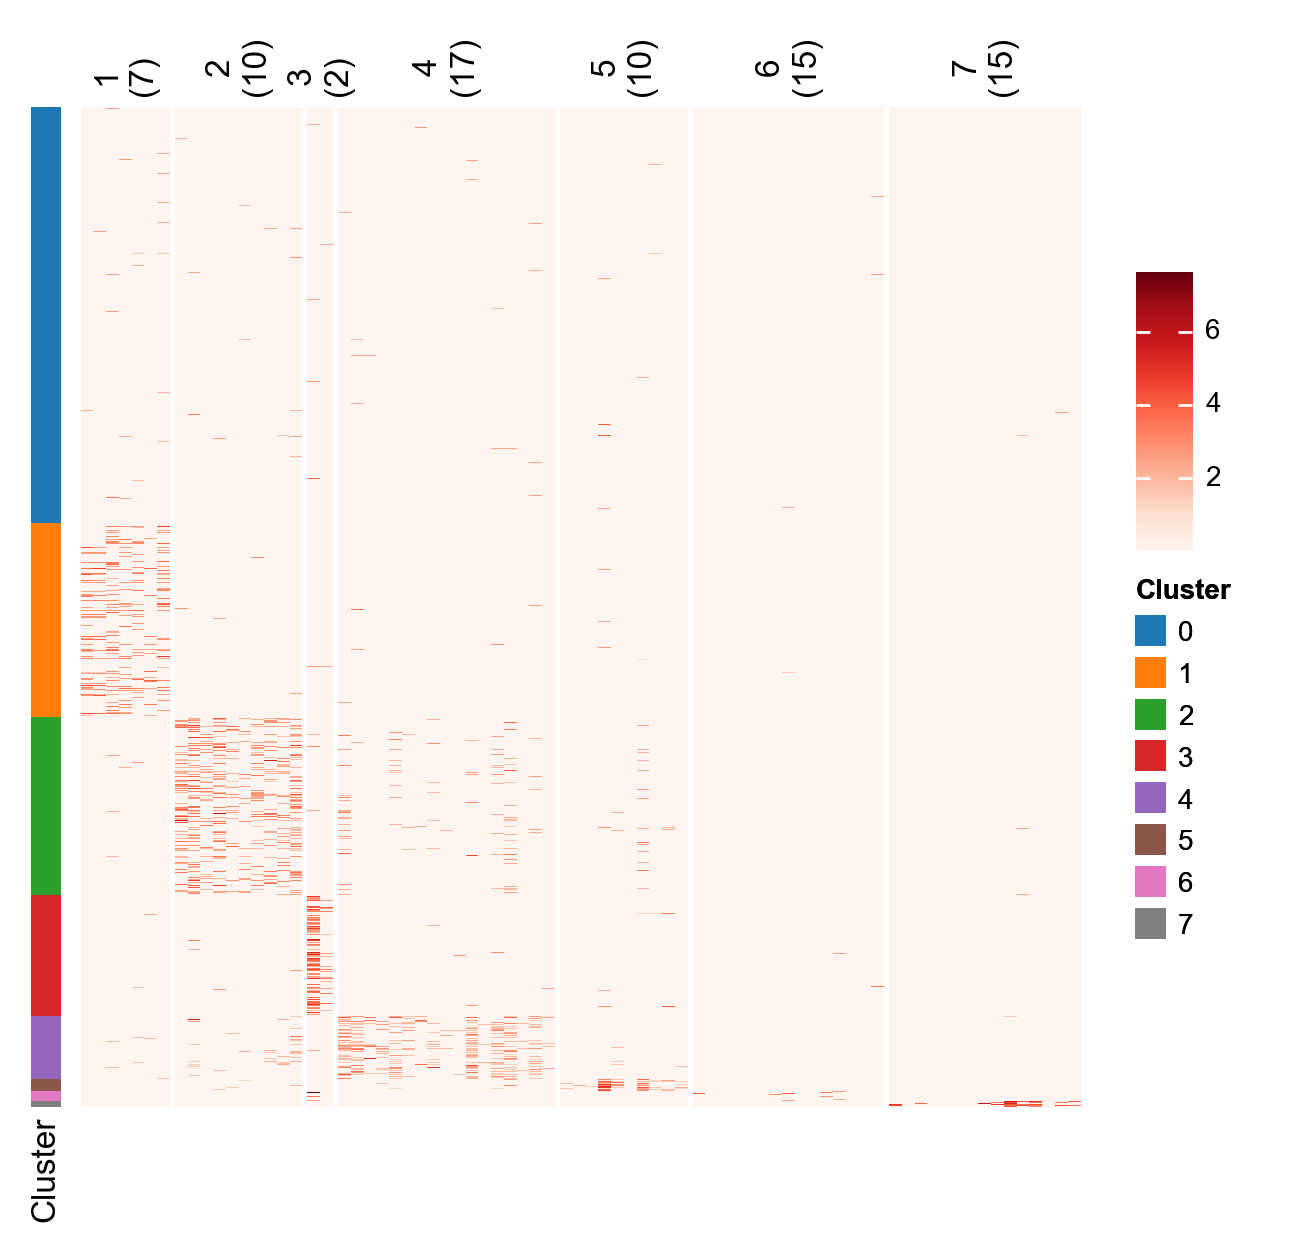

In [57]:
ead.pl.heatmapGeneExp(None, 'Cluster', dt_specGenes, height=5, width=5, showGeneCounts=True).render()

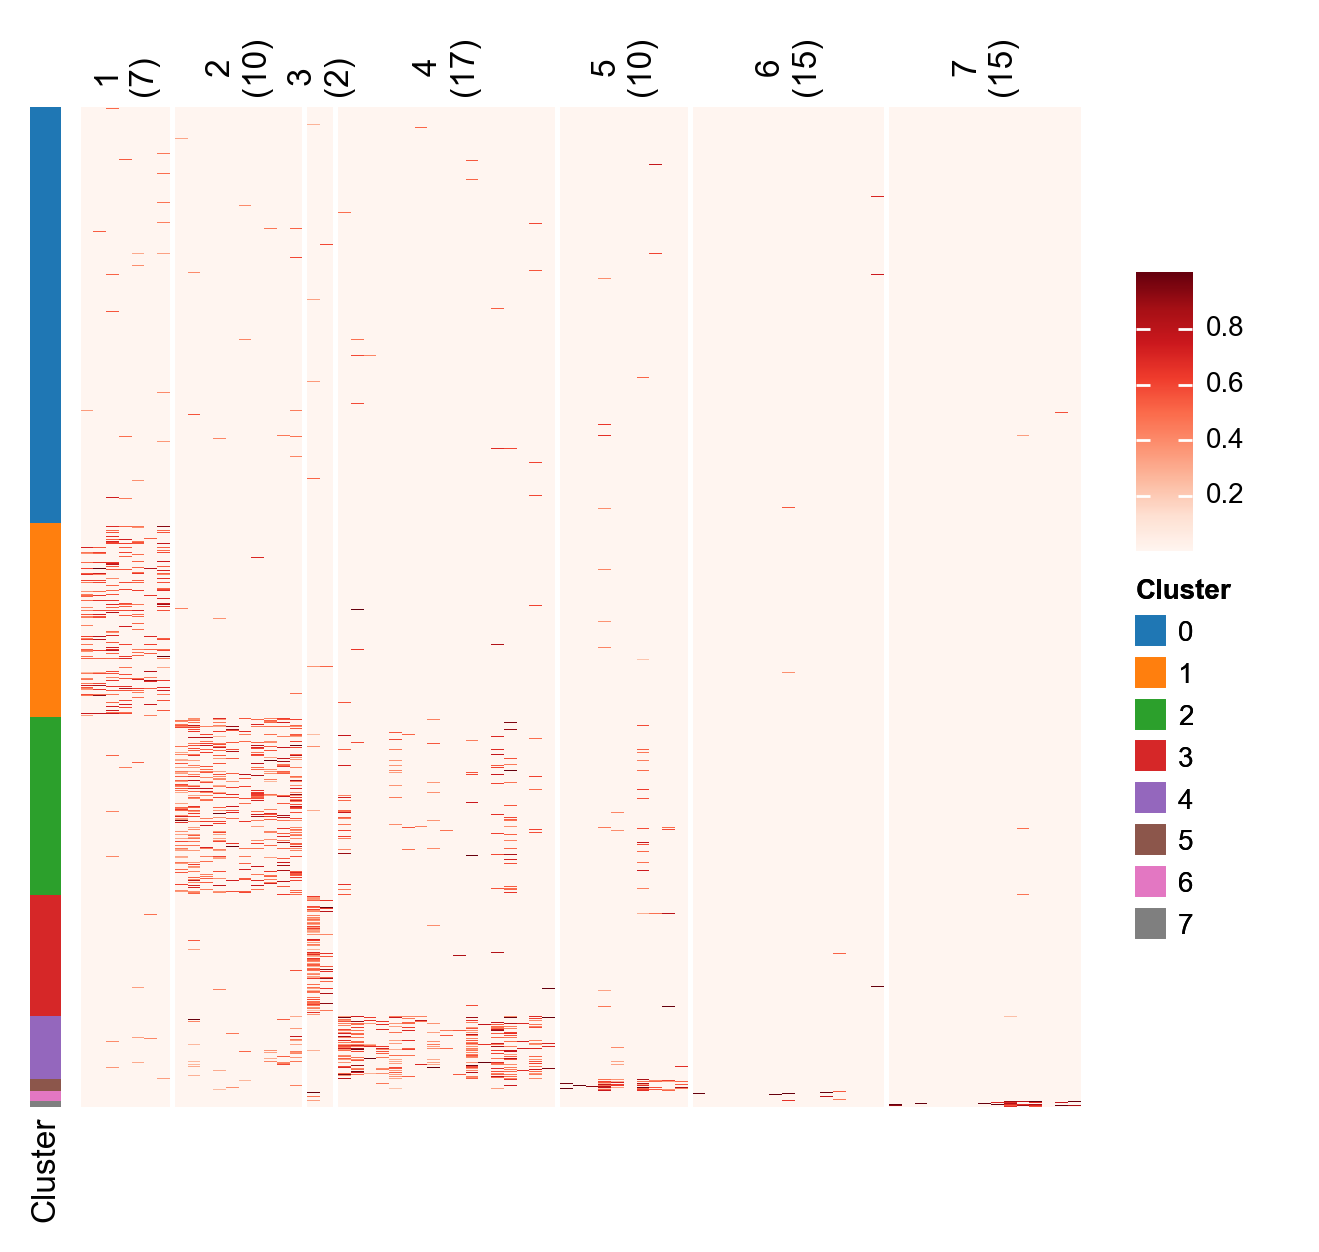

In [59]:
ead.pl.heatmapGeneExp(None, 'Cluster', dt_specGenes, height=5, width=5, showGeneCounts=True, standardScale=0).render()

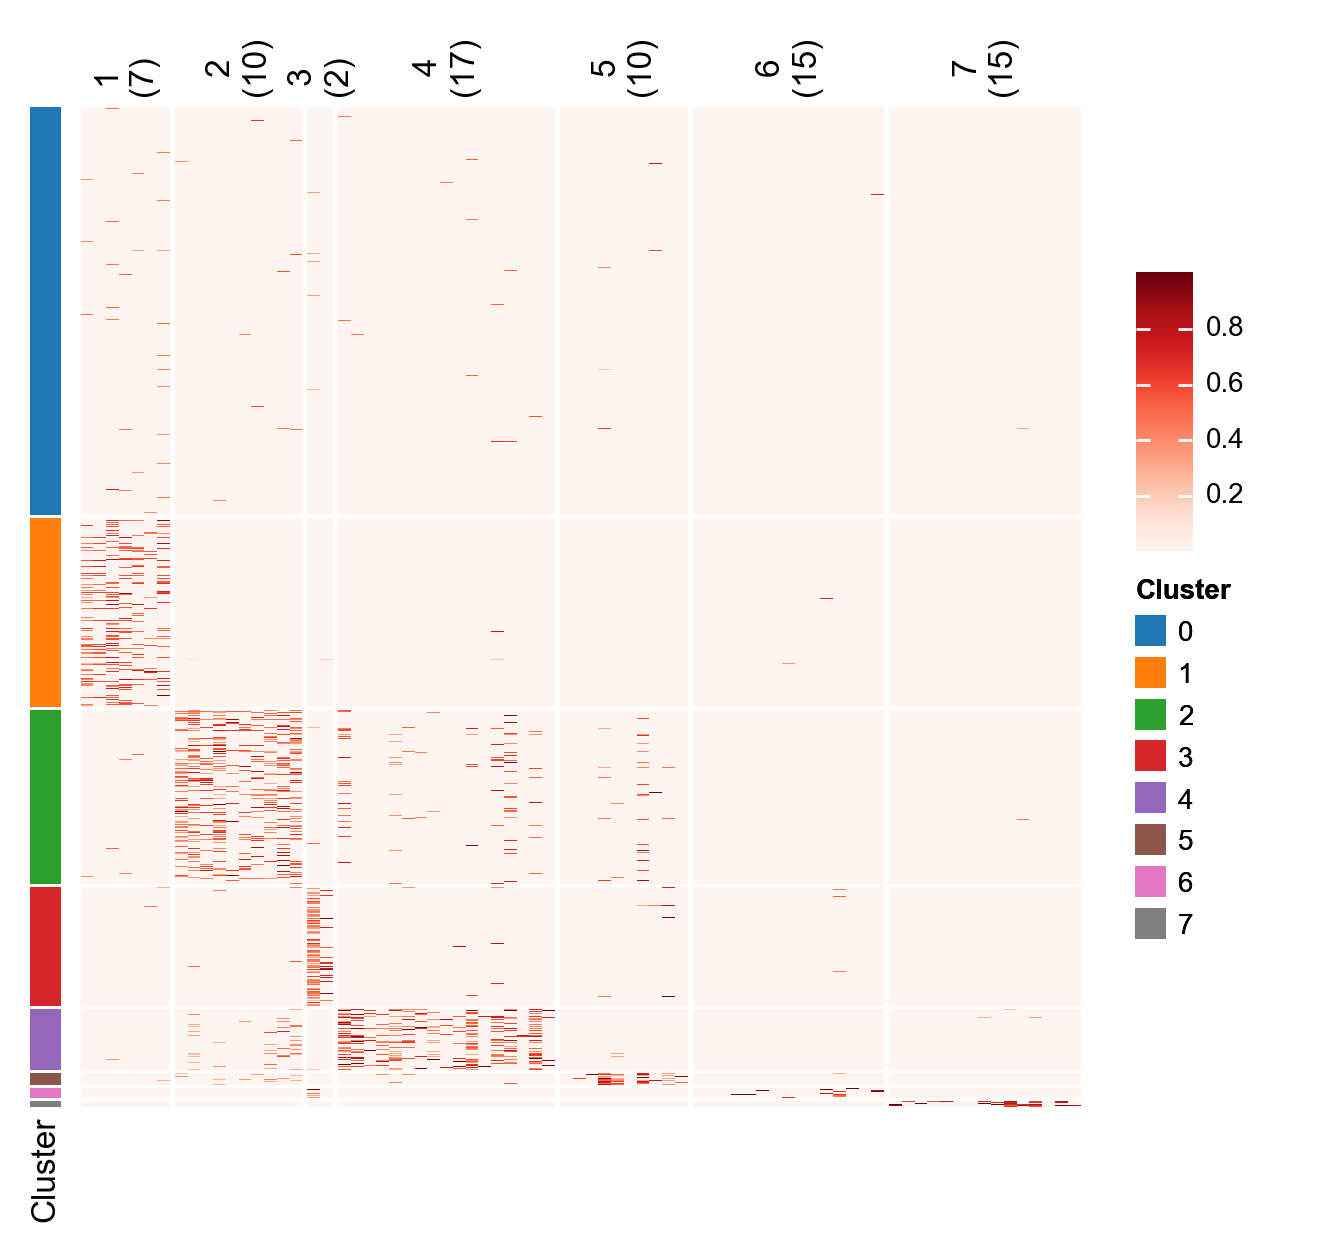

In [62]:
ead.pl.heatmapGeneExp(None, 'Cluster', dt_specGenes, cellSplitBy='Cluster', height=5, width=5, showGeneCounts=True, standardScale=0).render()

2024-03-31 15:01:15.516 | WARNING  | jpy_tools.singleCellTools.basic:testAllCountIsInt:318 - Make sure that adata.layer contains unnormalized count data	Layer:count


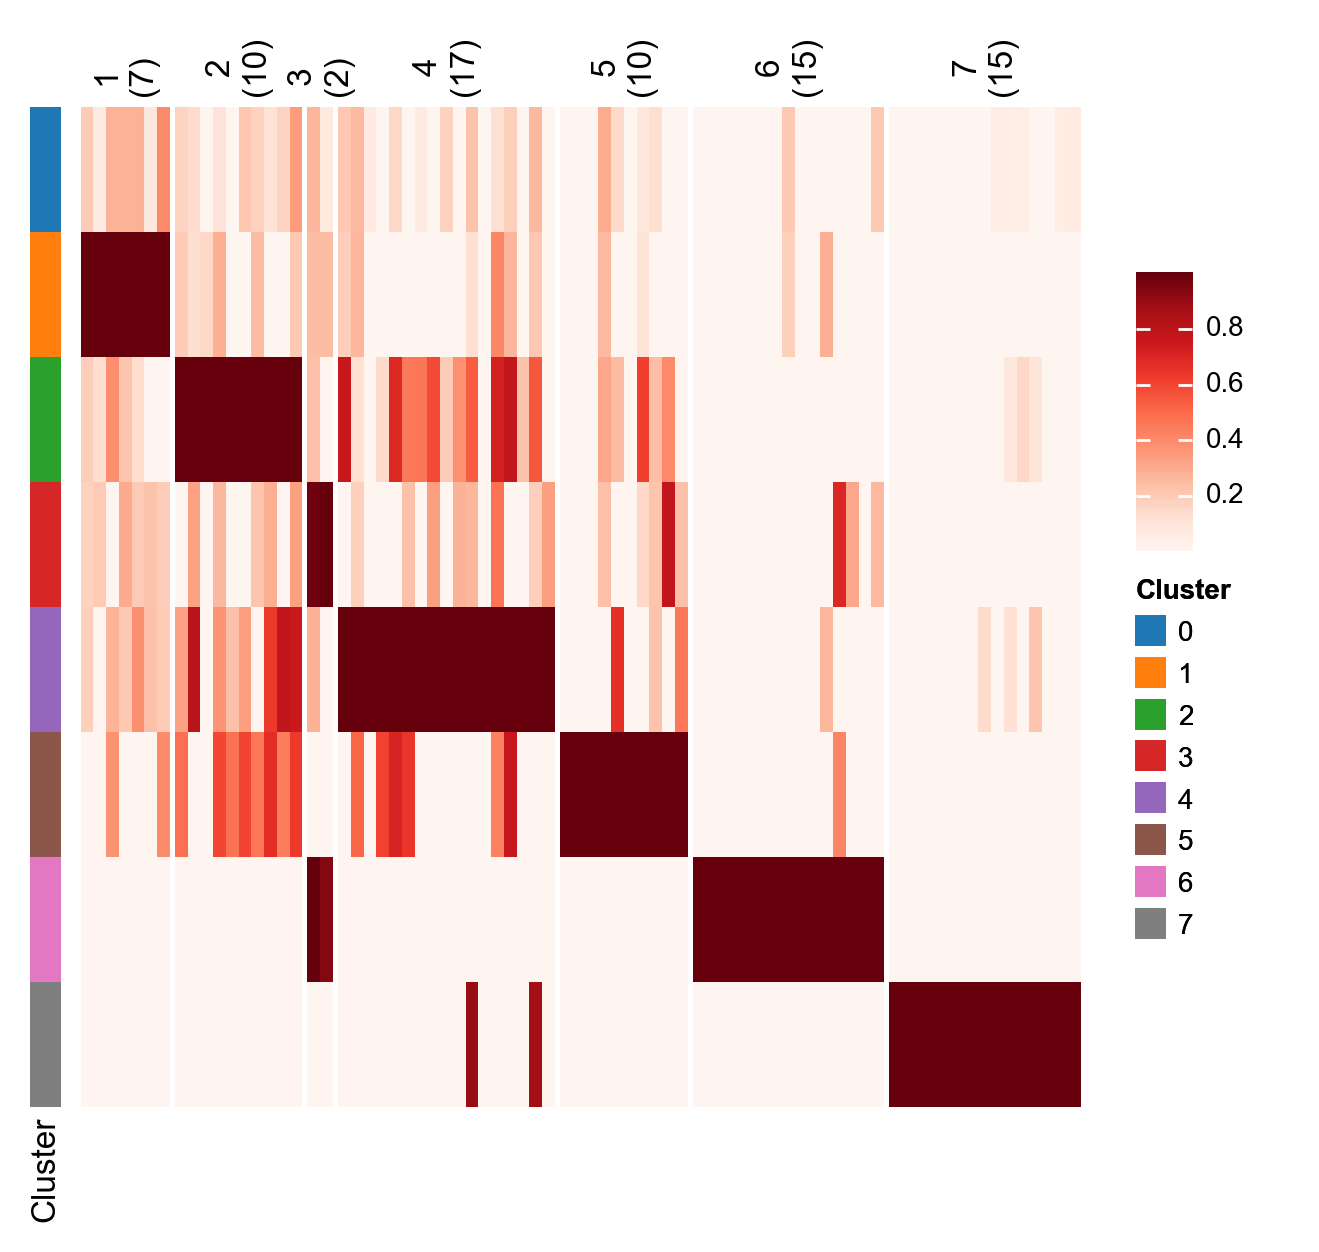

In [60]:
ead.pl.heatmapGeneExp('Cluster', 'Cluster', dt_specGenes, height=5, width=5, showGeneCounts=True, standardScale=0).render()

#### Gene Set Score

In [65]:
ead.addRef(ead.ad, 'Cluster') # a trick to add a reference to the original cluster, thus activate `anno`` mode

In [66]:
ead.anno.getAUCellScore(dt_specGenes)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


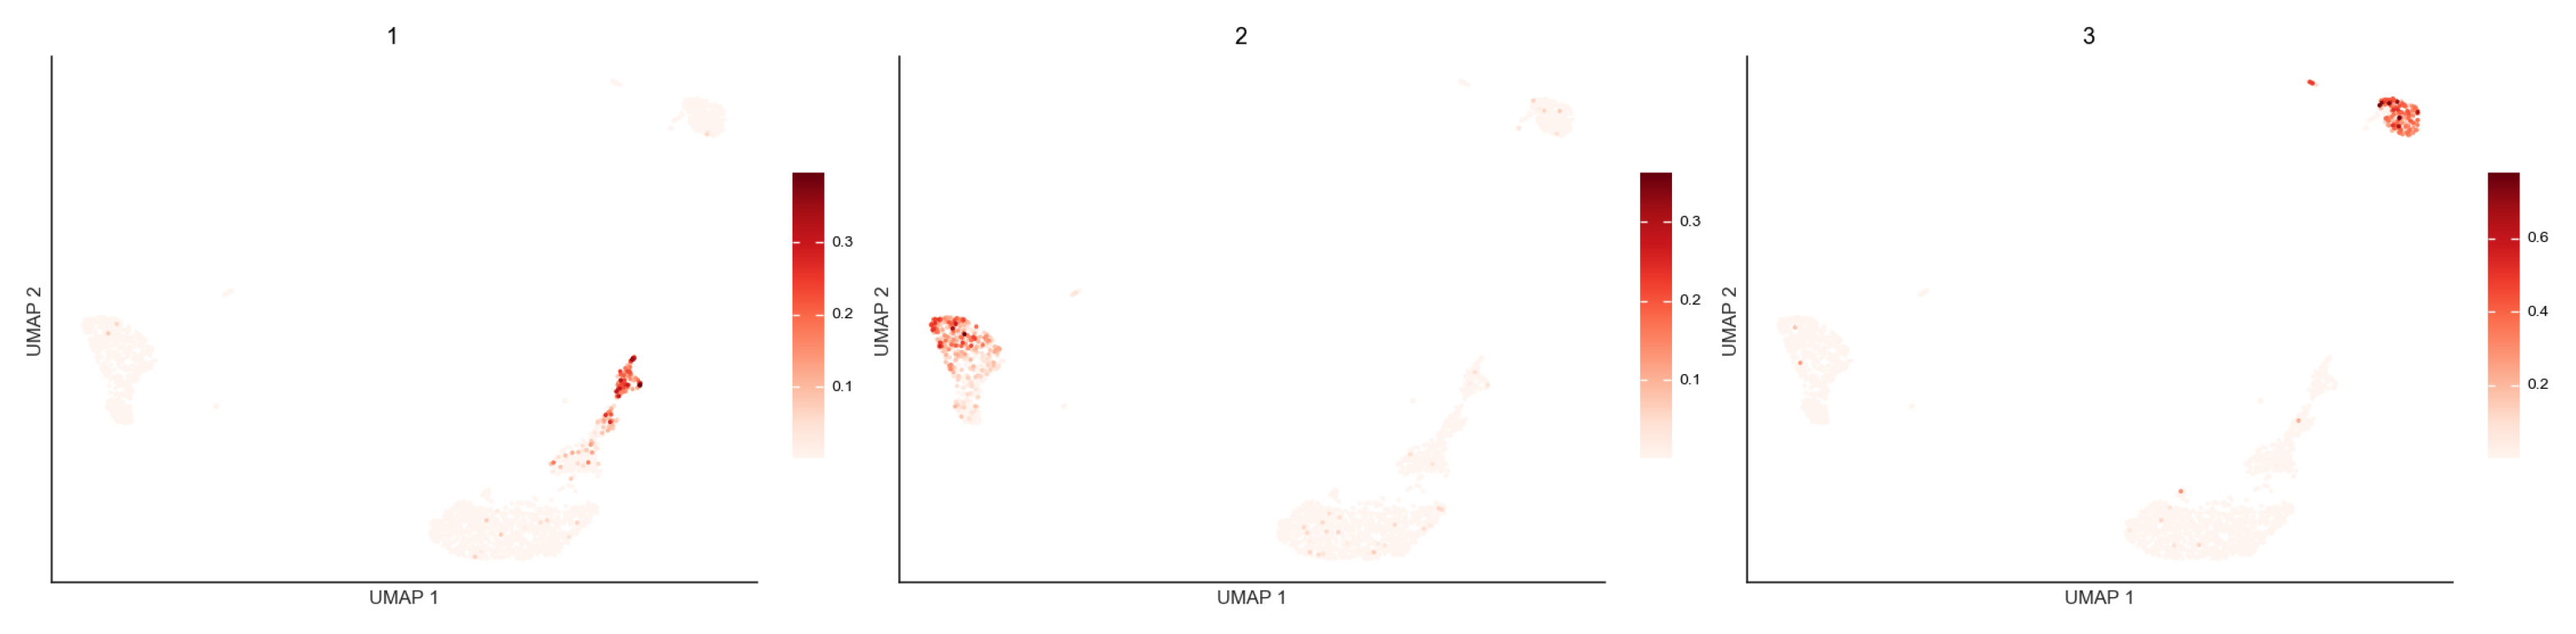

In [86]:
ead.pl.embedding('umap', ['1', '2', '3'], colorUseObsm='AUCell').show([20, 20])

## Other Choices

### SCT

In [94]:
ead

enhancedAnndata: AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'temp_0.1', 'temp_0.12', 'temp_0.14', 'temp_0.16', 'temp_0.18', 'temp_0.2', 'temp_0.22', 'temp_0.24', 'temp_0.26', 'temp_0.28', 'temp_0.3', 'temp_0.32', 'temp_0.34', 'temp_0.36', 'temp_0.38', 'temp_0.4', 'temp_0.42', 'temp_0.44', 'temp_0.46', 'temp_0.48', 'temp_0.5', 'temp_0.52', 'temp_0.54', 'temp_0.56', 'temp_0.58', 'temp_0.6', 'temp_0.62', 'temp_0.64', 'temp_0.66', 'temp_0.68', 'temp_0.7', 'temp_0.72', 'temp_0.74', 'temp_0.76', 'temp_0.78', 'temp_0.8', 'temp_0.82', 'temp_0.84', 'temp_0.86', 'temp_0.88', 'temp_0.9', 'temp_0.92', 'temp_0.94', 'temp_0.96', 'temp_0.98', 'temp_1.0', 'temp_1.02', 'temp_1.04', 'temp_1.06', 'temp_1.08', 'Cluster'
    var: 'gene_symbols', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'EnhancedAnndata_rawLayer', 'log1p', 'hvg', 'pca', 'lastNorm', 'neighbors', 'leiden', 'umap', 'pseudobulk_anndata', 'Cluster_colors', 'temp_0.4_colors', '

In [96]:
ead.norm.normBySct()

2024-03-31 16:04:37 - WARNING - R[write to console]: Warning:
2024-03-31 16:04:37 - WARNING - R[write to console]:  Adding a Graph without an assay associated with it

2024-03-31 16:04:37 - WARNING - R[write to console]: Warning:
2024-03-31 16:04:37 - WARNING - R[write to console]:  Adding a Graph without an assay associated with it

2024-03-31 16:04:38 - WARNING - R[write to console]: vst.flavor='v2' set, setting model to use fixed slope and exclude poisson genes.

2024-03-31 16:04:38 - WARNING - R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

2024-03-31 16:04:38 - WARNING - R[write to console]: Total Step 1 genes: 12572

2024-03-31 16:04:38 - WARNING - R[write to console]: Total overdispersed genes: 8724

2024-03-31 16:04:38 - WARNING - R[write to console]: Excluding 3848 genes from Step 1 because they are not overdispersed.

2024-03-31 16:04:39 - WARNING - R[write to console]: Variance stabilizing transformation of count matrix of size 12572 by 2700


  |======================================================================| 100%


2024-03-31 16:04:59 - WARNING - R[write to console]: Setting estimate of  33 genes to inf as theta_mm/theta_mle < 1e-3

2024-03-31 16:04:59 - WARNING - R[write to console]: # of step1 poisson genes (variance < mean): 0

2024-03-31 16:04:59 - WARNING - R[write to console]: # of low mean genes (mean < 0.001): 0

2024-03-31 16:04:59 - WARNING - R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 33

2024-03-31 16:04:59 - WARNING - R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 3848

2024-03-31 16:04:59 - WARNING - R[write to console]: Calling offset model for all 3848 poisson genes

2024-03-31 16:04:59 - WARNING - R[write to console]: Found 71 outliers - those will be ignored in fitting/regularization step


2024-03-31 16:04:59 - WARNING - R[write to console]: Ignoring theta inf genes

2024-03-31 16:05:01 - WARNING - R[write to console]: Replacing fit params for 3848 poisson genes by theta=Inf

2024-03-31 16:05:01 - WARNING - R[wr

  |======================================================================| 100%


2024-03-31 16:05:11 - WARNING - R[write to console]: Calculating gene attributes

2024-03-31 16:05:12 - WARNING - R[write to console]: Wall clock passed: Time difference of 34.05003 secs

2024-03-31 16:05:12 - WARNING - R[write to console]: Determine variable features

2024-03-31 16:05:13 - WARNING - R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==================                                                    |  25%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |====================================================                  |  75%
  |           

  |======================================================================| 100%


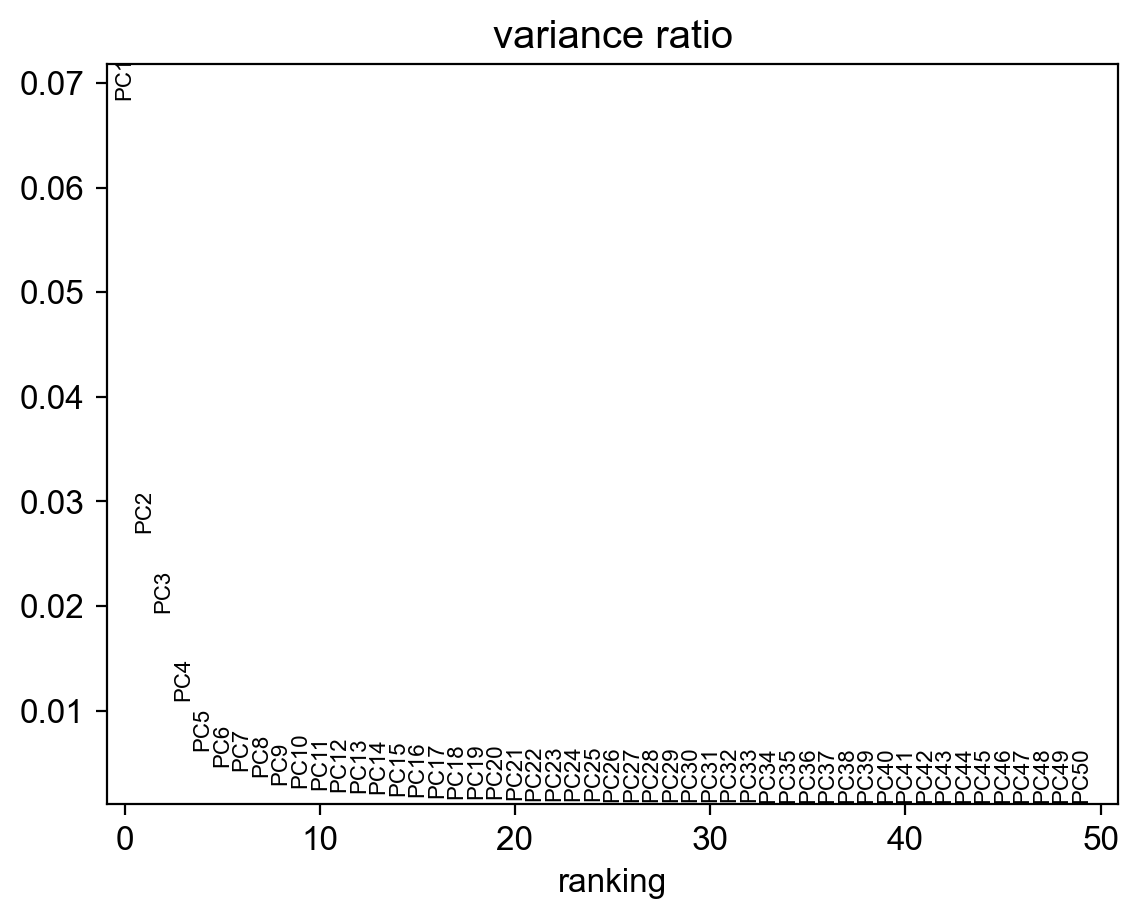

In [99]:
sc.pl.pca_variance_ratio(ead, 50)

In [100]:
sc.pp.neighbors(ead.ad, n_neighbors=25, n_pcs=20, metric='cosine')

#### find the optimal resolution

In [101]:
ls_res = [round(x,2) for x in list(np.arange(0.1, 1.1, 0.02))]

In [105]:
del(ead.obsm['leiden'])

2024-03-31 16:07:23.051 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1110 - clustering using leiden algorithm
2024-03-31 16:07:23.053 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1112 - used res: [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08]
silhouette_score: 100%|██████████| 50/50 [00:03<00:00, 16.05it/s]


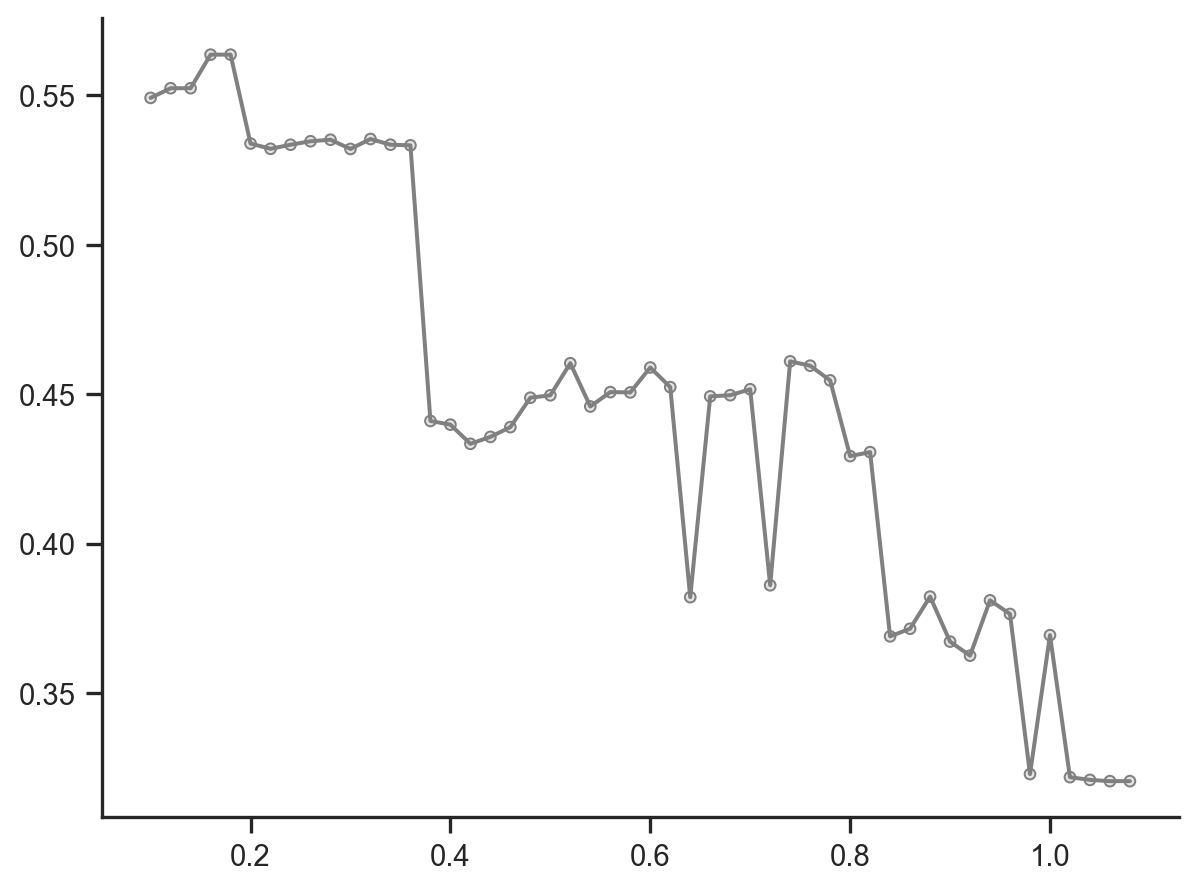

{0.1: 0.5491699,
 0.12: 0.5524136,
 0.14: 0.5524136,
 0.16: 0.5636532,
 0.18: 0.5636532,
 0.2: 0.53389734,
 0.22: 0.53213435,
 0.24: 0.53350633,
 0.26: 0.5346641,
 0.28: 0.5351758,
 0.3: 0.5320847,
 0.32: 0.5354155,
 0.34: 0.53350633,
 0.36: 0.53329355,
 0.38: 0.4410319,
 0.4: 0.43980497,
 0.42: 0.43338206,
 0.44: 0.43570447,
 0.46: 0.43897253,
 0.48: 0.44881275,
 0.5: 0.44962928,
 0.52: 0.46036458,
 0.54: 0.44587868,
 0.56: 0.4506927,
 0.58: 0.45058703,
 0.6: 0.4589273,
 0.62: 0.45236173,
 0.64: 0.38205403,
 0.66: 0.44925514,
 0.68: 0.44965756,
 0.7: 0.45164225,
 0.72: 0.3860395,
 0.74: 0.46099547,
 0.76: 0.45953107,
 0.78: 0.4546185,
 0.8: 0.4292668,
 0.82: 0.4306081,
 0.84: 0.36894003,
 0.86: 0.37149101,
 0.88: 0.38223538,
 0.9: 0.36718744,
 0.92: 0.3624707,
 0.94: 0.38099098,
 0.96: 0.37641987,
 0.98: 0.3228364,
 1.0: 0.36932695,
 1.02: 0.32179815,
 1.04: 0.3208819,
 1.06: 0.3204689,
 1.08: 0.3204689}

In [106]:
ead.cl.getShilouetteScore(ls_res, obsm='X_pca', metric='cosine', pcs=20)

In [107]:
ead.obs['Cluster'] = ead.obsm['leiden']['0.18']

#### UMAP

In [109]:
sc.tl.umap(ead.ad, 0.1)

2024-03-31 16:08:27.420 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6'], dtype='object')


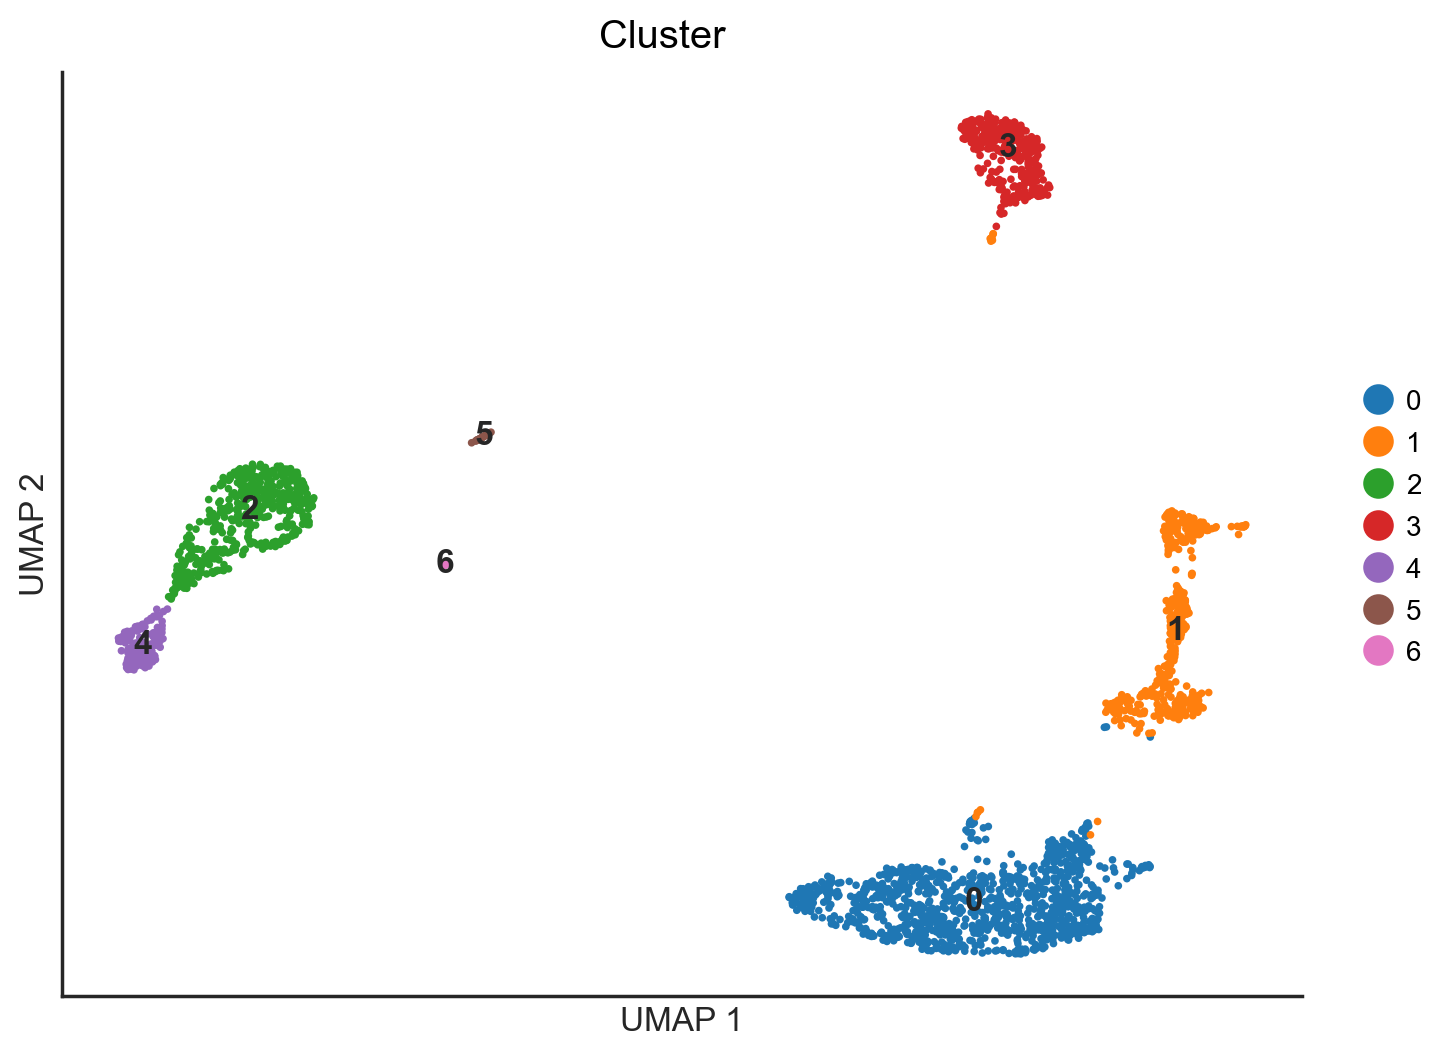

In [110]:
ead.pl.embedding('umap', color='Cluster', legendInFig=True)

## Shared NN

In [168]:
ead.cl.getSeuratSnn('X_pca', 24, 20)

2024-03-31 16:45:33 - WARNING - R[write to console]: Computing nearest neighbor graph

2024-03-31 16:45:34 - WARNING - R[write to console]: Computing SNN

2024-03-31 16:45:35.895 | INFO     | jpy_tools.rTools:so2ad:578 - assay RNA: Variable features are already calculated. 3000 features are selected.


In [170]:
ead

enhancedAnndata: AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'temp_0.1', 'temp_0.12', 'temp_0.14', 'temp_0.16', 'temp_0.18', 'temp_0.2', 'temp_0.22', 'temp_0.24', 'temp_0.26', 'temp_0.28', 'temp_0.3', 'temp_0.32', 'temp_0.34', 'temp_0.36', 'temp_0.38', 'temp_0.4', 'temp_0.42', 'temp_0.44', 'temp_0.46', 'temp_0.48', 'temp_0.5', 'temp_0.52', 'temp_0.54', 'temp_0.56', 'temp_0.58', 'temp_0.6', 'temp_0.62', 'temp_0.64', 'temp_0.66', 'temp_0.68', 'temp_0.7', 'temp_0.72', 'temp_0.74', 'temp_0.76', 'temp_0.78', 'temp_0.8', 'temp_0.82', 'temp_0.84', 'temp_0.86', 'temp_0.88', 'temp_0.9', 'temp_0.92', 'temp_0.94', 'temp_0.96', 'temp_0.98', 'temp_1.0', 'temp_1.02', 'temp_1.04', 'temp_1.06', 'temp_1.08', 'Cluster', 'leiden'
    var: 'gene_symbols', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'EnhancedAnndata_rawLayer', 'log1p', 'hvg', 'pca', 'lastNorm', 'neighbors', 'leiden', 'umap', 'pseudobulk_anndata', 'Cluster_colors', 'temp_0.4_

In [171]:
sc.tl.leiden(ead.ad, obsp='connectivities', key_added='scanpy_p')
sc.tl.leiden(ead.ad, obsp='seurat', key_added='seurat_nn')
sc.tl.leiden(ead.ad, obsp='seurat_snn', key_added='seurat_snn')

2024-03-31 16:47:20.061 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15'],
      dtype='object')
2024-03-31 16:47:20.745 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], dtype='object')
2024-03-31 16:47:21.272 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13'],
      dtype='object')


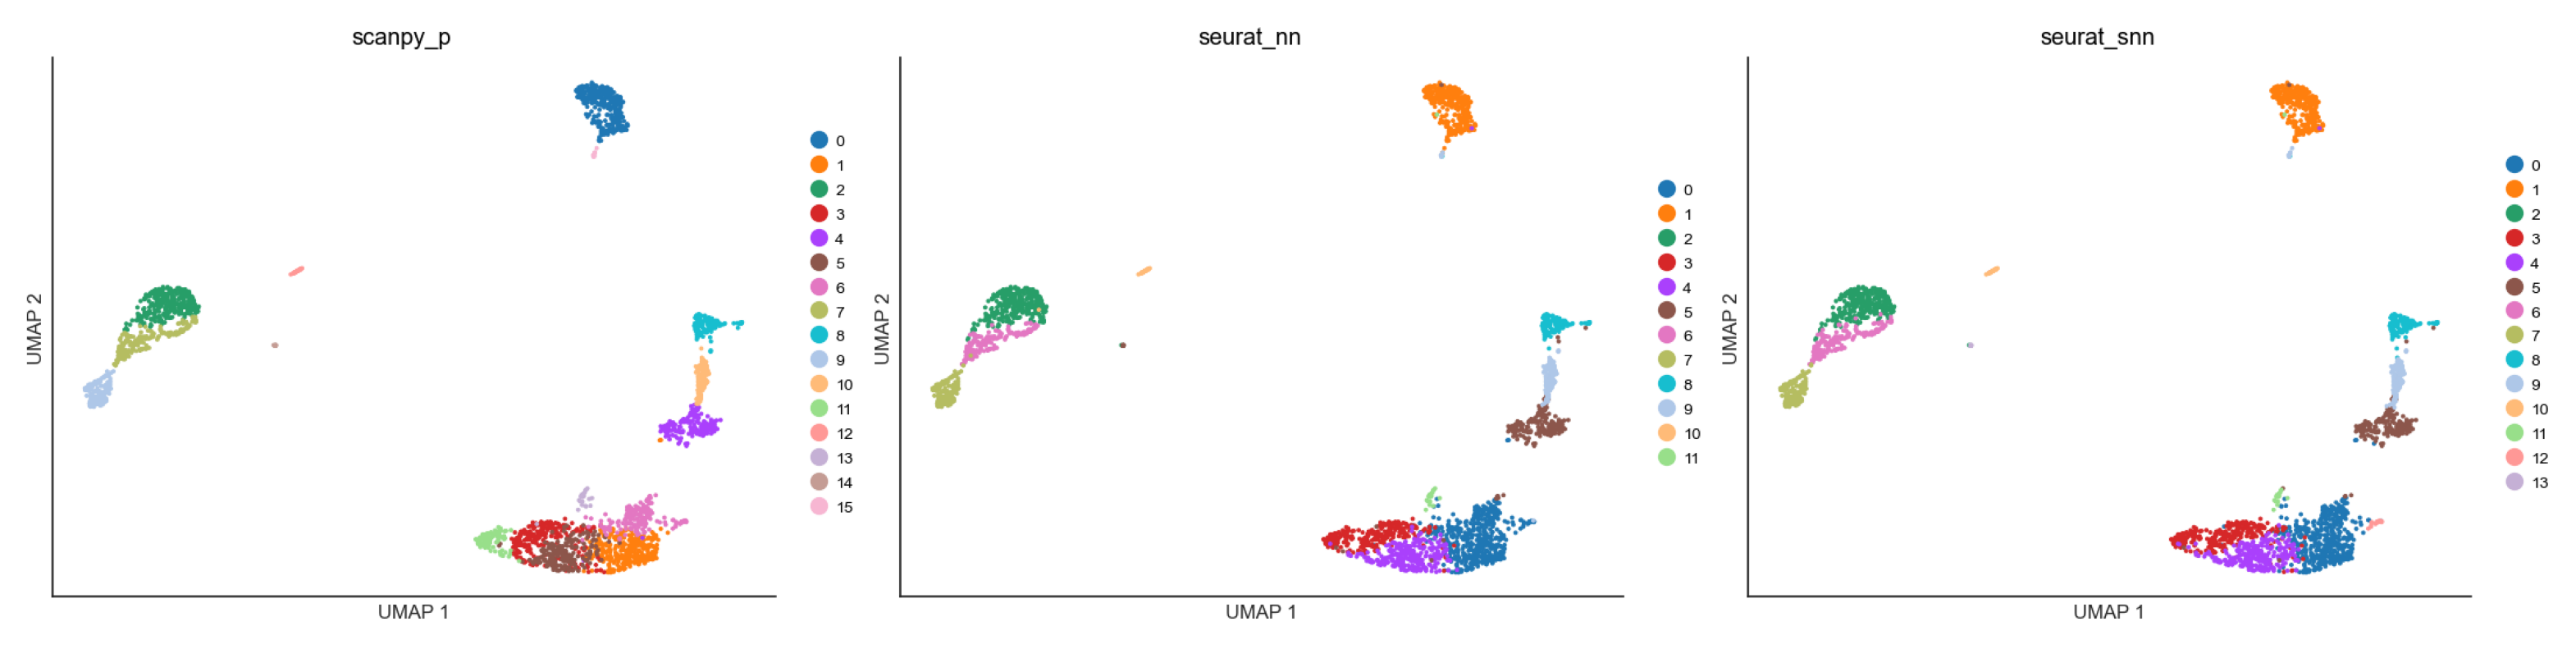

In [173]:
ead.pl.embedding(color=['scanpy_p', 'seurat_nn', 'seurat_snn'], ).show((20,20))

## With Reps

In [175]:
ead.ad.obs = ead.ad.obs[[]]

In [177]:
ead.ad.obs['Rep'] = np.random.choice(['a', 'b'],ead.ad.shape[0])

### APR

In [186]:
ead.rawLayer

'count'

In [189]:
ead.norm.normByApr(batchKey='Rep')

2024-03-31 16:54:22.041 | WARNING  | jpy_tools.singleCellTools.basic:testAllCountIsInt:318 - Make sure that adata.layer contains unnormalized count data	Layer:binarized
100%|██████████| 2/2 [00:00<00:00,  8.01it/s]


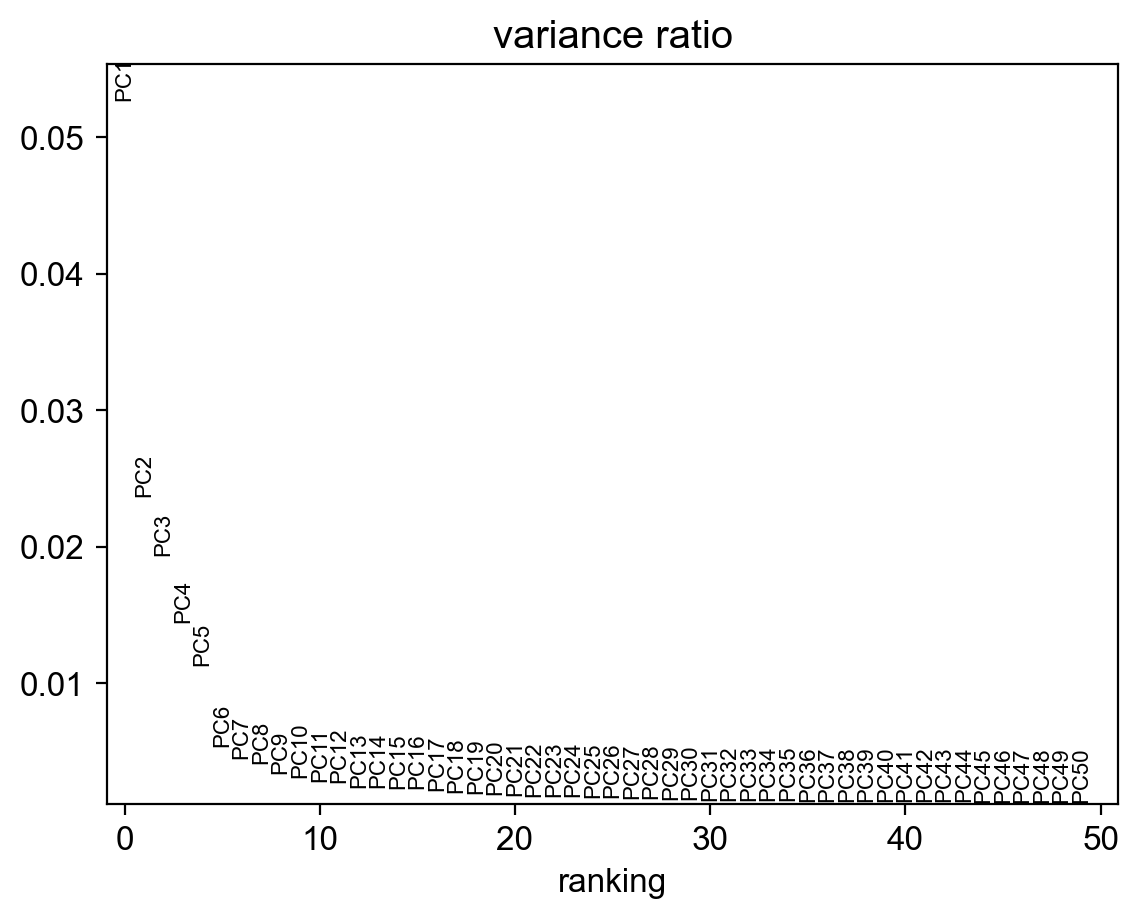

In [190]:
sc.pl.pca_variance_ratio(ead, 50)

In [192]:
sc.pp.neighbors(ead.ad, n_neighbors=25, n_pcs=20, metric='cosine')

#### find the optimal resolution

In [193]:
ls_res = [round(x,2) for x in list(np.arange(0.1, 1.1, 0.02))]

In [195]:
del(ead.obsm['leiden'])

2024-03-31 16:55:45.163 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1110 - clustering using leiden algorithm
2024-03-31 16:55:45.166 | INFO     | jpy_tools.singleCellTools.others:clusteringAndCalculateShilouetteScore:1112 - used res: [0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46, 0.48, 0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08]
silhouette_score: 100%|██████████| 50/50 [00:03<00:00, 15.88it/s]


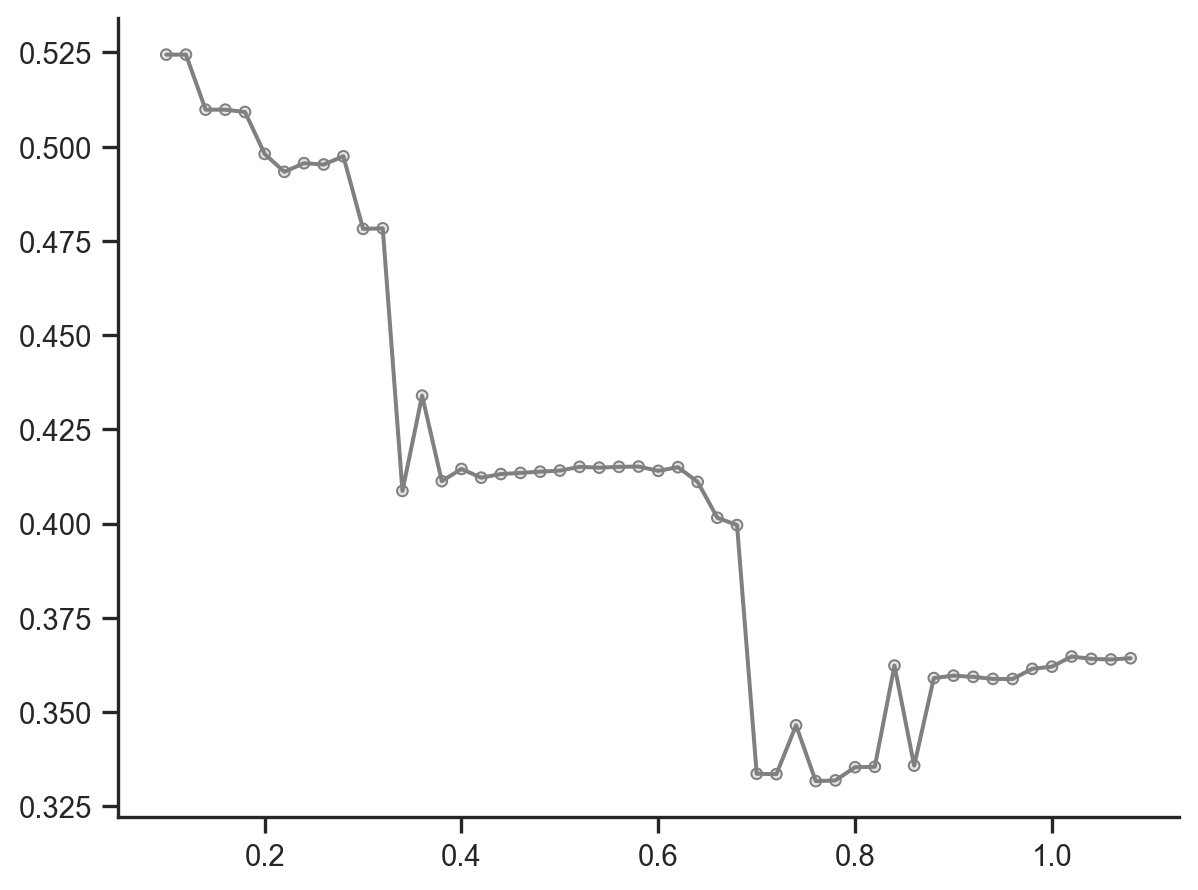

{0.1: 0.5244258,
 0.12: 0.5244258,
 0.14: 0.5098236,
 0.16: 0.5098236,
 0.18: 0.50921065,
 0.2: 0.49808213,
 0.22: 0.49332818,
 0.24: 0.49563125,
 0.26: 0.49526882,
 0.28: 0.49745208,
 0.3: 0.4781948,
 0.32: 0.4783327,
 0.34: 0.40867102,
 0.36: 0.4339606,
 0.38: 0.41126037,
 0.4: 0.4145014,
 0.42: 0.41218352,
 0.44: 0.41314837,
 0.46: 0.4134518,
 0.48: 0.4137776,
 0.5: 0.4140654,
 0.52: 0.41505417,
 0.54: 0.41484347,
 0.56: 0.41505417,
 0.58: 0.4151355,
 0.6: 0.41400033,
 0.62: 0.41496402,
 0.64: 0.41105393,
 0.66: 0.40155894,
 0.68: 0.39960024,
 0.7: 0.3336258,
 0.72: 0.33351395,
 0.74: 0.3464811,
 0.76: 0.33166704,
 0.78: 0.3318582,
 0.8: 0.33536634,
 0.82: 0.33547735,
 0.84: 0.36233023,
 0.86: 0.33578184,
 0.88: 0.3590121,
 0.9: 0.35965827,
 0.92: 0.35933778,
 0.94: 0.35879314,
 0.96: 0.35877165,
 0.98: 0.36146706,
 1.0: 0.36204773,
 1.02: 0.36473018,
 1.04: 0.36411408,
 1.06: 0.3639488,
 1.08: 0.36427823}

In [196]:
ead.cl.getShilouetteScore(ls_res, obsm='X_pca', metric='cosine', pcs=20)

In [197]:
ead.obs['Cluster'] = ead.obsm['leiden']['0.2']

#### UMAP

In [198]:
sc.tl.umap(ead.ad, 0.1)

2024-03-31 16:56:55.133 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')
2024-03-31 16:56:55.630 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['a', 'b'], dtype='object')


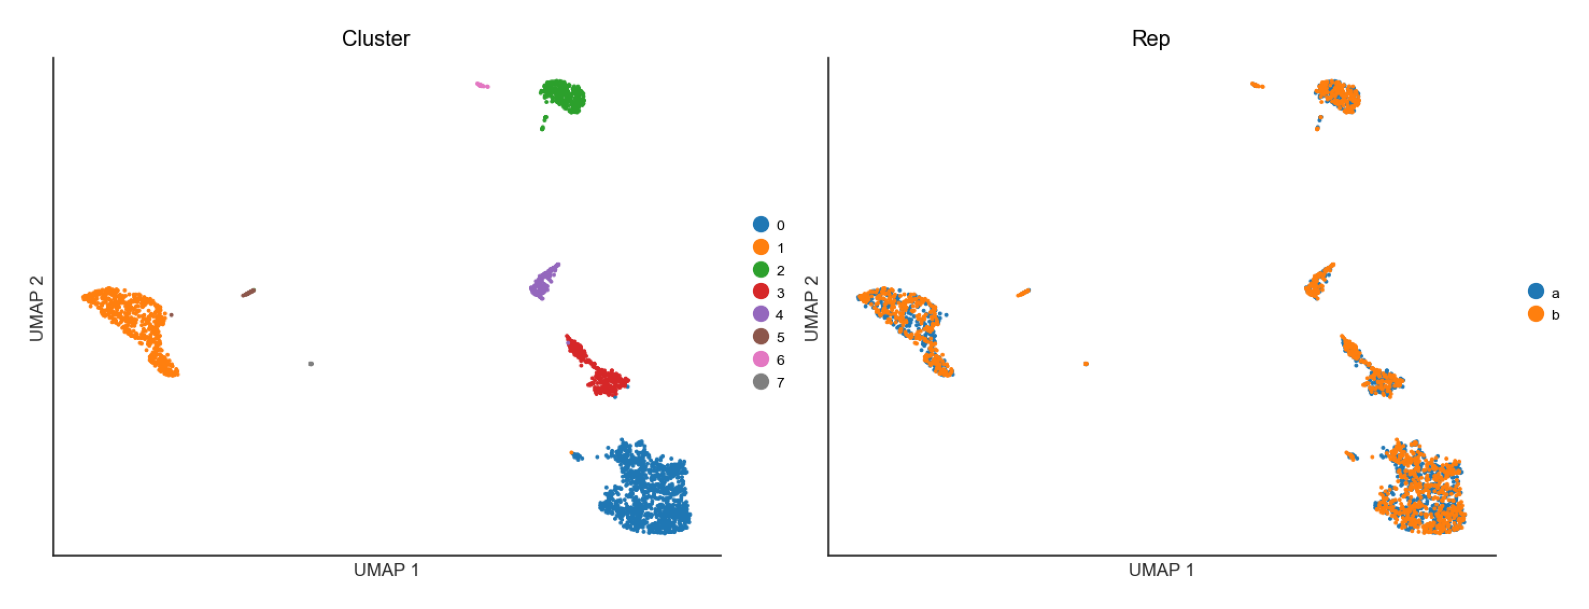

In [201]:
ead.pl.embedding('umap', color=['Cluster', 'Rep']).show()

2024-03-31 16:58:14.222 | WARNING  | jpy_tools.singleCellTools.plotting:embedding:1756 - Both groupby and multiple colors are provided. `Wrap` will be ignored.
2024-03-31 16:58:14.225 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5'], dtype='object')
2024-03-31 16:58:14.963 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object')


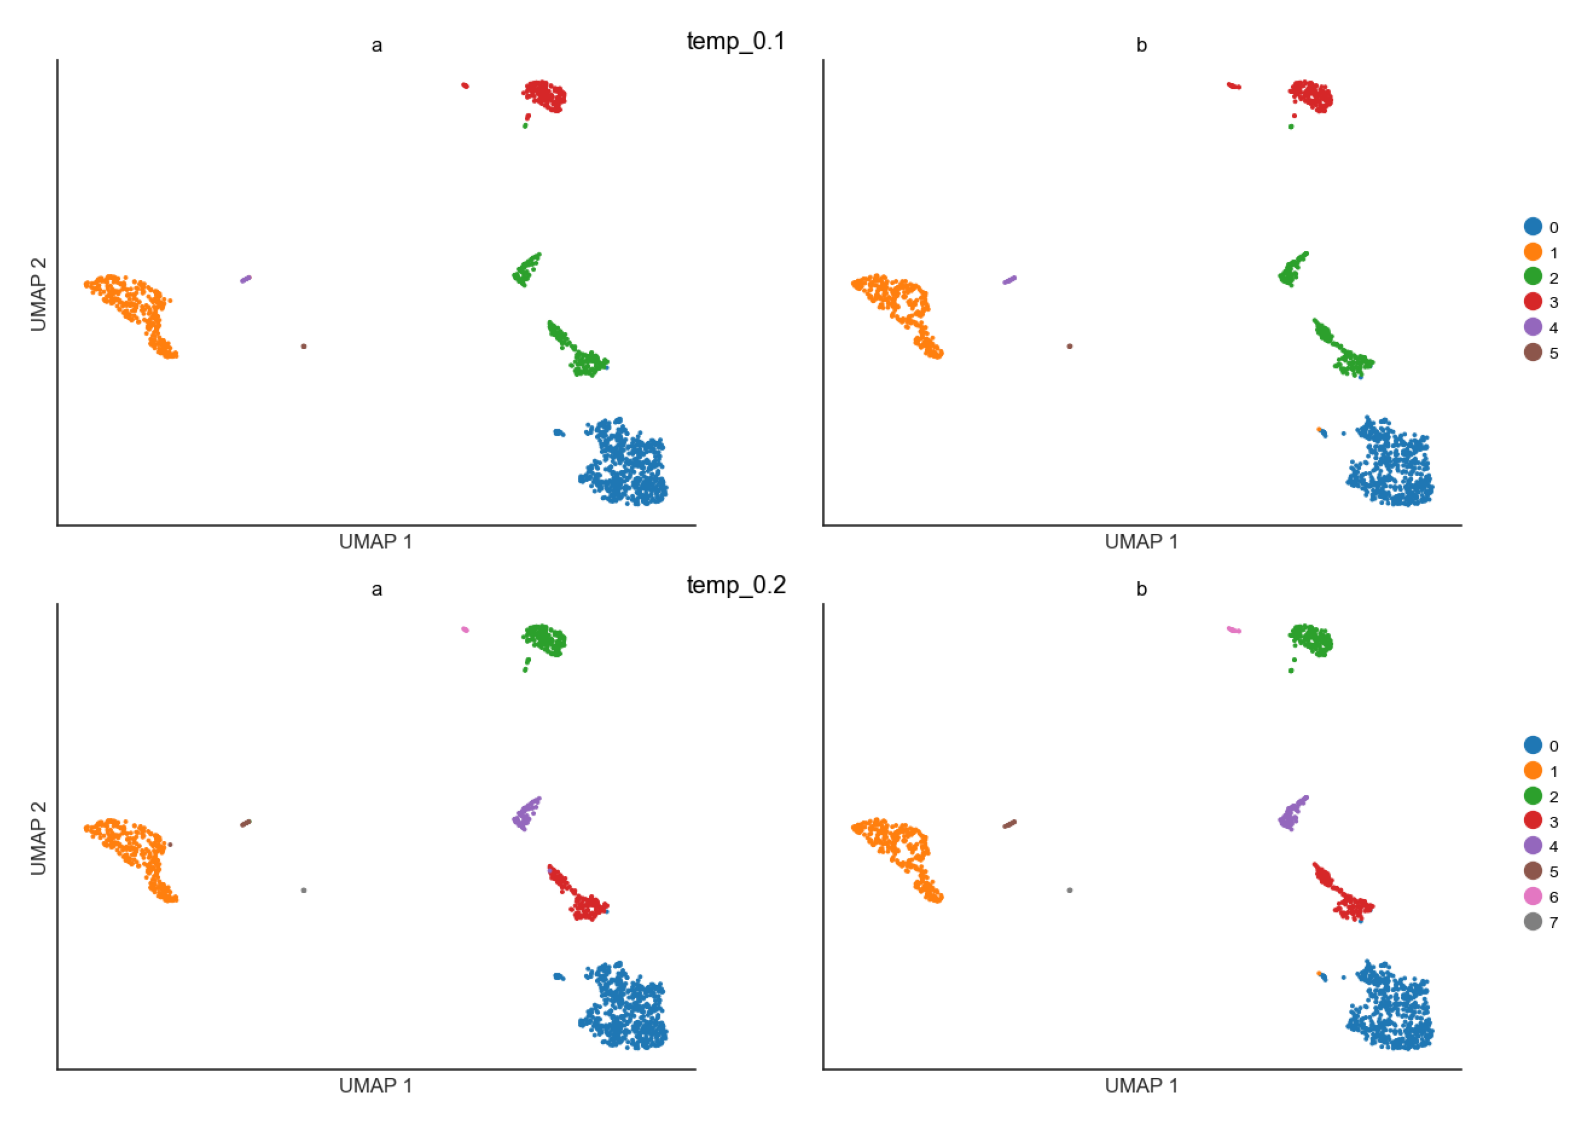

In [205]:
ead.pl.embedding('umap', color=['temp_0.1', 'temp_0.2'], groupby='Rep',figsize=(15, 5)).show()

## SCT

In [220]:
def reloadPackages(package):
    import importlib
    from types import ModuleType
    for p in dir(package):
        p = getattr(package, p)
        if isinstance(p, ModuleType):
            importlib.reload(p)
    importlib.reload(package)
reloadPackages(singleCellTools)

In [221]:
ead = singleCellTools.EnhancedAnndata(ead.ad, 'count')

2024-03-31 17:08:57.850 | WARNING  | jpy_tools.singleCellTools:rawLayer:442 - rawLayer will be overwritten by count and all the related objects will be re-initialized


In [222]:
del(ead.obsm['sct_residual'])

In [223]:
ead.norm.normBySct('Rep')

  0%|          | 0/2 [00:00<?, ?it/s]2024-03-31 17:09:17 - WARNING - R[write to console]: Warning:
2024-03-31 17:09:17 - WARNING - R[write to console]:  Invalid name supplied, making object name syntactically valid. New object name is Reptemp_0.1temp_0.12temp_0.14temp_0.16temp_0.18temp_0.2temp_0.22temp_0.24temp_0.26temp_0.28temp_0.3temp_0.32temp_0.34temp_0.36temp_0.38temp_0.4temp_0.42temp_0.44temp_0.46temp_0.48temp_0.5temp_0.52temp_0.54temp_0.56temp_0.58temp_0.6temp_0.62temp_0.64temp_0.66temp_0.68temp_0.7temp_0.72temp_0.74temp_0.76temp_0.78temp_0.8temp_0.82temp_0.84temp_0.86temp_0.88temp_0.9temp_0.92temp_0.94temp_0.96temp_0.98temp_1.0temp_1.02temp_1.04temp_1.06temp_1.08ClusterX__group; see ?make.names for more details on syntax validity

2024-03-31 17:09:21 - WARNING - R[write to console]: Warning:
2024-03-31 17:09:21 - WARNING - R[write to console]:  Adding a Graph without an assay associated with it

2024-03-31 17:09:21 - WARNING - R[write to console]: Warning:
2024-03-31 17:09:21 - 

  |======================================================================| 100%


2024-03-31 17:09:36 - WARNING - R[write to console]: Setting estimate of  46 genes to inf as theta_mm/theta_mle < 1e-3

2024-03-31 17:09:36 - WARNING - R[write to console]: # of step1 poisson genes (variance < mean): 0

2024-03-31 17:09:36 - WARNING - R[write to console]: # of low mean genes (mean < 0.001): 0

2024-03-31 17:09:36 - WARNING - R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 46

2024-03-31 17:09:36 - WARNING - R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 4025

2024-03-31 17:09:36 - WARNING - R[write to console]: Calling offset model for all 4025 poisson genes

2024-03-31 17:09:36 - WARNING - R[write to console]: Found 84 outliers - those will be ignored in fitting/regularization step


2024-03-31 17:09:36 - WARNING - R[write to console]: Ignoring theta inf genes

2024-03-31 17:09:37 - WARNING - R[write to console]: Replacing fit params for 4025 poisson genes by theta=Inf

2024-03-31 17:09:37 - WARNING - R[wr

  |======================================================================| 100%


2024-03-31 17:09:42 - WARNING - R[write to console]: Calculating gene attributes

2024-03-31 17:09:42 - WARNING - R[write to console]: Wall clock passed: Time difference of 20.44882 secs

2024-03-31 17:09:42 - WARNING - R[write to console]: Determine variable features

2024-03-31 17:09:43 - WARNING - R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==================                                                    |  25%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |====================================================                  |  75%
  |           

  |======================================================================| 100%


2024-03-31 17:10:14 - WARNING - R[write to console]: Setting estimate of  54 genes to inf as theta_mm/theta_mle < 1e-3

2024-03-31 17:10:14 - WARNING - R[write to console]: # of step1 poisson genes (variance < mean): 0

2024-03-31 17:10:14 - WARNING - R[write to console]: # of low mean genes (mean < 0.001): 0

2024-03-31 17:10:14 - WARNING - R[write to console]: Total # of Step1 poisson genes (theta=Inf; variance < mean): 54

2024-03-31 17:10:14 - WARNING - R[write to console]: Total # of poisson genes (theta=Inf; variance < mean): 4067

2024-03-31 17:10:14 - WARNING - R[write to console]: Calling offset model for all 4067 poisson genes

2024-03-31 17:10:14 - WARNING - R[write to console]: Found 100 outliers - those will be ignored in fitting/regularization step


2024-03-31 17:10:14 - WARNING - R[write to console]: Ignoring theta inf genes

2024-03-31 17:10:15 - WARNING - R[write to console]: Replacing fit params for 4067 poisson genes by theta=Inf

2024-03-31 17:10:15 - WARNING - R[w

  |======================================================================| 100%


2024-03-31 17:10:19 - WARNING - R[write to console]: Calculating gene attributes

2024-03-31 17:10:19 - WARNING - R[write to console]: Wall clock passed: Time difference of 19.71664 secs

2024-03-31 17:10:19 - WARNING - R[write to console]: Determine variable features

2024-03-31 17:10:20 - WARNING - R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==================                                                    |  25%
  |                                                                            
  |===================================                                   |  50%
  |                                                                            
  |====================================================                  |  75%
  |           

  |======================================================================| 100%


 50%|█████     | 1/2 [00:06<00:06,  6.36s/it]2024-03-31 17:10:37 - WARNING - R[write to console]: Setting min_variance based on median UMI:  0.04

2024-03-31 17:10:37 - WARNING - R[write to console]: Calculating residuals of type pearson for 3000 genes



  |======================================================================| 100%


100%|██████████| 2/2 [00:14<00:00,  7.35s/it]


In [226]:
sc.pp.neighbors(ead.ad, n_neighbors=25, n_pcs=20, metric='cosine')

In [227]:
sc.tl.leiden(ead.ad)

In [228]:
sc.tl.umap(ead.ad, 0.1)

2024-03-31 17:12:09.619 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16'],
      dtype='object')
2024-03-31 17:12:10.254 | DEBUG    | jpy_tools.singleCellTools.plotting:_embedding:1583 - ls_color: Index(['a', 'b'], dtype='object')


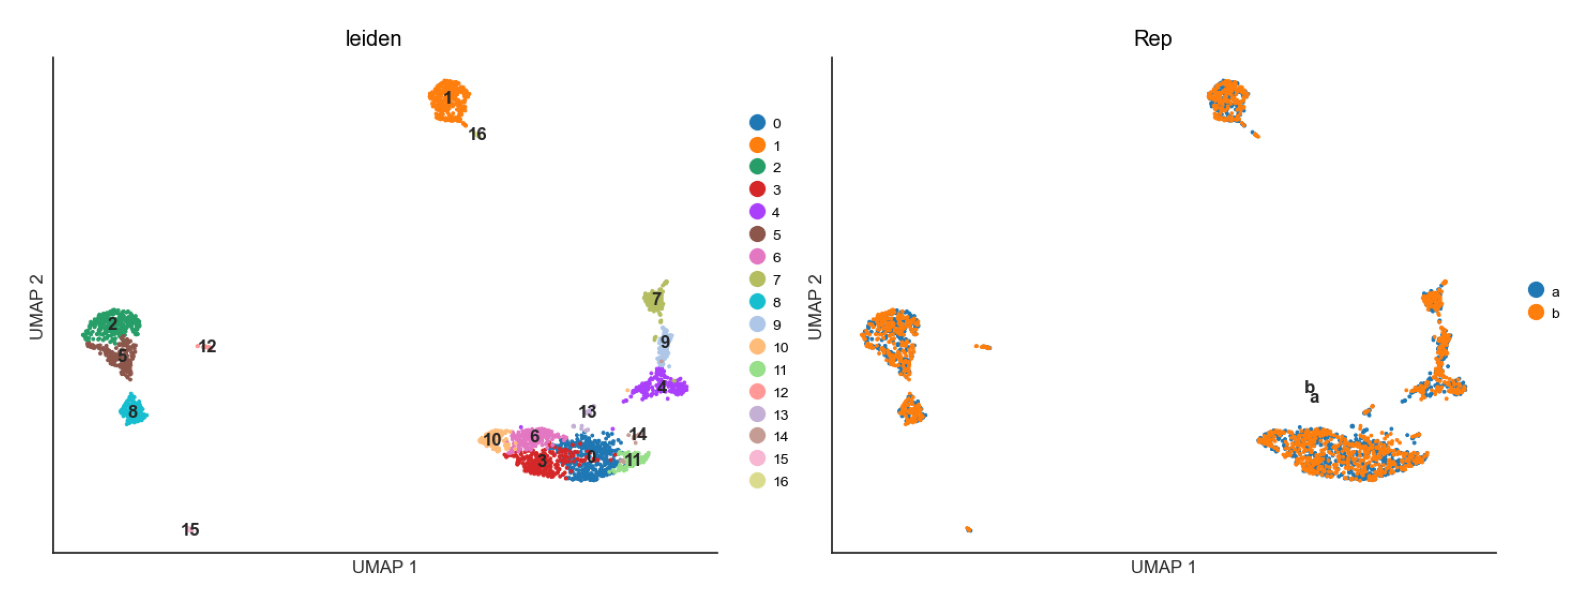

In [229]:
ead.pl.embedding('umap', color=['leiden', 'Rep'], legendInFig=True).show()